In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [2]:
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW, ElectraTokenizer
# from transformers import DistilBertTokenizer, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report

# GPU 사용
device = torch.device("cuda")

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/nv_bj_one.csv')
df['id'] = df['id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df.head()

,id,name,cat_id
0,38241346937-310300400,쟈딕앤볼테르 Kayak 카키 아모르 카모 레터링 프린트 야상 자켓 점퍼,310300400
1,39945841940-310300400,카인 후드 바람막이 점퍼,310300400
2,40085020674-310300400,데이나믹 툴린스 고어텍스 여자 후드 윈드브레이커 자켓 20897733 1A00008...,310300400
3,38856225697-310300400,ZOOC 반팔 데님자켓 Z222PSF403 1544239,310300400
4,83356850408-310300400,봄 오버핏 힙합 점퍼 가을 데님 여성 재킷 야상 스트릿 아우터 여자 야구 학생,310300400


In [4]:
# -- preprocessing --

def split_data(df):
    # format changes
    df['name'] = "[CLS] " + df['name'] + " [SEP]"

    # encoding
    encoder = LabelEncoder()
    # df['label'] = encoder.fit_transform(df['maincat_id']) # main
    # df['label'] = encoder.fit_transform(df['midcat_id']) # mid
    df['label'] = encoder.fit_transform(df['cat_id']) # sub

    # train, test dataset split
    train_x, test_x, train_y, test_y = train_test_split(df['name'], df['label'].values, random_state=42, test_size=0.2)
    train_df, test_df = df.loc[train_x.index], df.loc[test_x.index]
    return train_df, test_df, encoder

train_df, test_df, encoder = split_data(df)

In [5]:
# -- converting inputs
def convert_input(sentences):
    tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

input_ids, attention_masks = convert_input(train_df['name'])

In [6]:
# -- train and validation set --
def split_train_and_validation(input_ids, attention_masks):
    train_x, val_x, train_y, val_y = train_test_split(input_ids, train_df['label'].values, random_state=5, test_size=.2)
    train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=5, test_size=.2)

    # tensor로 만들기
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    train_mask = torch.tensor(train_mask)

    val_x = torch.tensor(val_x)
    val_y = torch.tensor(val_y)
    val_mask = torch.tensor(val_mask)

    # dataloader
    batch_size = 32
    train_data = TensorDataset(train_x, train_mask, train_y)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    val_data = TensorDataset(val_x, val_mask, val_y)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = split_train_and_validation(input_ids, attention_masks)

In [7]:
# -- setting device --
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.


In [8]:
# -- koelectra_v3_small --
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-small-v3-discriminator",
                                                         num_labels=df['cat_id'].nunique(), # *3 필요없음
                                                         )
model.cuda()

epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

In [9]:
from sklearn.metrics import accuracy_score
# -- model training --
# 시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# 그래디언트 초기화
model.zero_grad()
loss_list, acc_list = [], []
for epoch in tqdm(range(0, epochs)):
    total_loss = 0
    model.train()
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        outputs = model(input_ids= b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0] # 이 부분 수정 필요
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        model.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)

    model.eval()
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in val_dataloader:

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
        logits = outputs.logits
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate accuracy based on top 3 labels predicted
        predictions = np.argsort(logits, axis=1)[:, -3:]  # Get indices of top 3 labels
        accuracy = np.mean([1 if label in pred else 0 for label, pred in zip(label_ids, predictions)])

        eval_accuracy += accuracy

        nb_eval_steps += 1

    acc_list.append(round(eval_accuracy / nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy : 0.8922


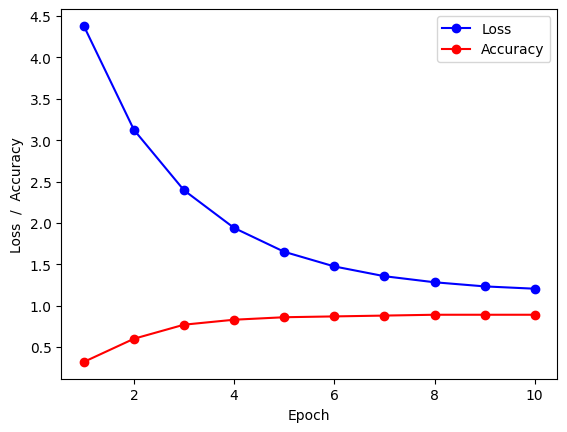

In [10]:
# -- sub category loss and accuracy with top 3 labels --
epoch = range(1, epochs+1)
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 4)}')

In [11]:
# 모델 저장
PATH = '/content/drive/MyDrive/'
torch.save(model, PATH + 'koelectra_small_model_for_ensemble.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'koelectra_small_model_state_dict_for_ensemble.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'koelectra_small_all_for_ensemble.tar')

In [ ]:
# -- 전이 학습 ------------------------

In [14]:
# optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH + 'koelectra_small_model_v2.pt')  # 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/koelectra_small_model_state_dict_v2.pt'))

optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)

checkpoint = torch.load(PATH + 'koelectra_small_all_v2.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [15]:
def test_sentences(sentences):
    model.eval()
    # 문장을 입력 데이터로 변환
    input_ids, attention_masks = convert_input(sentences)
    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    predictions = np.argsort(logits, axis=1)[:, -3:]  # Get indices of top 3 labels

    return predictions

# -- converting inputs --
def convert_input(sentences):
    tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-small-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

In [16]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,name,cat_id,label
0,82142717842-320210400,[CLS] 티뷰크 남성 스트라이프 셔츠 TB1912 [SEP],320210400,46
1,222822763,[CLS] 세련된 실버 뱅글 링팔찌 [SEP],422300200,114
2,39290864034-310260600,[CLS] 숏클립할인 플랜 하트 프린팅 여유핏 숏 맨투맨티 E742 [SEP],310260600,23
3,40621696240-320160800,[CLS] 남성 깅엄 체크 순면 잠옷 세트 홈웨어 파자마 사계절 여름 [SEP],320160800,40
4,35634428043-405300200,[CLS] 남성워커 남자 군화 전투화 패브릭 부츠 워커 사막화 [SEP],405300200,81


In [17]:
for idx in tqdm(range(len(test_df))):
    preds = test_sentences([test_df.name[idx]])
    top_labels = ' '.join(str(label) for label in preds[0])
    test_df.at[idx, 'predicted'] = top_labels

  0%|          | 0/34500 [00:00<?, ?it/s]

In [18]:
accuracy = 0
for idx in tqdm(range(len(test_df))):
    # -- 여기 코드 변경 필요 --
    if str(test_df.loc[idx, 'label']) in test_df.loc[idx, 'predicted'].split(' '): # 띄어쓰기로 split
        accuracy += 1
print(accuracy / len(test_df))

  0%|          | 0/34500 [00:00<?, ?it/s]

0.9046376811594203
